In [100]:
from lib.model import fromcrn,DoubleExclusive
from scipy.interpolate import UnivariateSpline
from os import system
from lib.colors import cyan,yellow
from matplotlib.pyplot import *
from numpy import *
from scipy.interpolate import interp2d

In [37]:
def doit(C6,C12):
    model = DoubleExclusive(nx=100,xmax=0.1)
    model.dt = 0.25

    p = 0.01

    model.state['diffusables'][:,0][model.space<p] = model.xmax * C6 / p
    model.state['diffusables'][:,1][model.space>(model.xmax-p)] = model.xmax * C12 / p

    T = 10000
    inhibitors = []
    diffusables = []

    while model.time[-1] < T :

        model.time_step() 
        inhibitors += [array(model.state['inhibitors'])]


    inhibitors = array(inhibitors)
    model.time = model.time[1:]


    # normalised fluorescence
    maximum,minimum = amax(inhibitors,axis=1),amin(inhibitors,axis=1)
    normalised_inhibitors = swapaxes( (swapaxes(inhibitors,0,1)-minimum)/(maximum-minimum) ,0,1)

    gamma_range = amax(inhibitors,axis=(0,1))
    gamma = inhibitors[:,:,0]/gamma_range[0]-inhibitors[:,:,1]/gamma_range[1]


    # calculate boundary dynamics
    boundaries = []
    slopes = []

    for inhibitor in normalised_inhibitors.T : 
        velocity,slope = gradient(inhibitor.T,model.time,model.space/model.space[-1])

        boundaries +=[ model.space[argmax(abs(slope),axis=1)] ]
        slopes += [ (arctan(amax(abs(slope),axis=1))-arctan(1.5))/ \
                    (arctan(100)-arctan(1.5)) ]

    boundaries = array(boundaries)
    slopes = array(slopes)

    mask = any(slopes>0.3,axis=0)
    mask *= abs(boundaries[0]-boundaries[1])/model.space[-1]<0.1


    figure(figsize=(7,7))
    contourf(model.space,model.time,gamma,
             cmap='BrBG',vmin=-1,vmax=1)

    plot(boundaries[0][mask],model.time[mask],
         color='black',linewidth=5)

    yscale('log')
    ylabel('Time, $t$ / min',fontsize=16)
    xlabel('Space, $x$ / cm',fontsize=16);

    figure(figsize=(7,7))
    plot(model.state['diffusables'])
#     plot(boundaries[0][mask]/0.1,'.',label='position')
#     plot(slopes[0][mask],'.',label='slope')
#     plot(slopes[1][mask],'.',label='slope')
#     ylim(0,1); legend();

#     boundary = UnivariateSpline(model.time[mask],boundaries[0][mask]/0.1,k=3, s=1e-1)
#     velocity = boundary.derivative()

#     return array([max(mean(slopes[0][mask]),mean(slopes[1][mask])),mean(velocity(model.time[mask]))])

CPU times: user 6.67 s, sys: 71.5 ms, total: 6.74 s
Wall time: 6.73 s


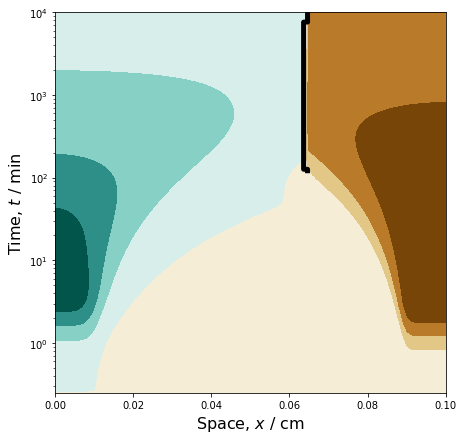

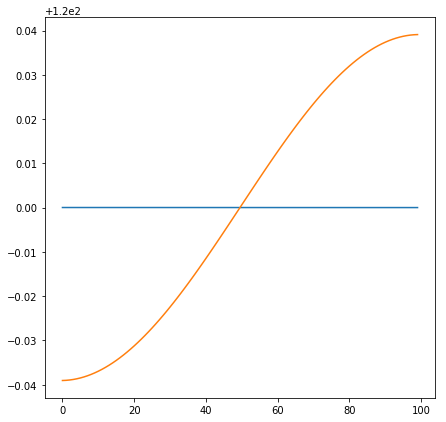

In [38]:
%time doit(120,120)

In [127]:
N=50;c_range=[-1,1];cdash_range=[0.5,1];clip=-0.5;eps=1e-3

eps = array([eps,-eps])
c_range = tuple(array(c_range)+eps)
cdash_range = tuple(array(cdash_range)+eps)

# initialisation of model
c = linspace(*c_range,num=N)
cdash = linspace(*cdash_range,num=N)
x,y = meshgrid(c,cdash,copy=False)
c_grid = dstack([x,y])

C6=520;C12=420
p = 0.01

model = DoubleExclusive()
model.dt = 0.25
model.state['diffusables'][:,1] = 6
model.state['diffusables'][:,0][model.space<p] = model.xmax * C6 / p
model.state['diffusables'][:,1][model.space>(model.xmax-p)] = model.xmax * C12 / p

# # calculation of steady states
# L,T = model.get_steady_state(c_grid,clip=clip)
# c6,c12 = model.get_diffusives(c_grid).reshape(2,N,N)

# create bifrucation figure
j = 0
for i in range(3000) :
    model.time_step()
    
    if i % 10 == 0 :
        
        figure(figsize=(10,10))

        contour(c6,c12,T[:,:,-1]-L[:,:,0],levels=[0],colors=['k'])
        contour(c6,c12,L[:,:,-1]-T[:,:,0],levels=[0],colors=['k'])
        contourf(c6,c12,L[:,:,0],cmap='cyan',alpha=0.25)
        contourf(c6,c12,L[:,:,-1],cmap='cyan',alpha=0.25)
        contourf(c6,c12,T[:,:,0],cmap='yellow',alpha=0.25)
        contourf(c6,c12,T[:,:,-1],cmap='yellow',alpha=0.25)
        
        plot(C6,C12,ms=10,marker='o',color='darkblue')
        plot(c6[0],C6+C12-c6[0],
             color='darkblue',linewidth=2,linestyle='--')

        mask = model.state['inhibitors'].T[0] > model.state['inhibitors'].T[1]
        plot(*model.state['diffusables'][mask].T,marker='.',
             linewidth=0,color='darkcyan')

        plot(*model.state['diffusables'][~mask].T,marker='.',
             linewidth=0,color='gold')

        xlabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)
        ylabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16)
        xscale('log')
        yscale('log')

        # labelling regions
        text(1e-5, 4,r'$Off$ State',fontsize=16)
        text(120, 3000,r'$Bistable$ Region',fontsize=16)
        text(1e-5, 100,r'$Monostable$ Region',fontsize=16)
        text(1e3, 10,r'$Monostable$ Region',fontsize=16);

        savefig(str(j).zfill(4)+'.png')
        close()
        j+=1

system('convert -delay 10 -loop 0 *.png c6-{}_c12-{}.gif'.format(C6,C12))
system('rm *.png')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract


0

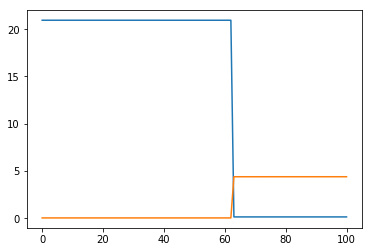

In [132]:
for i in range(10000) :
    model.time_step()
plot(model.state['inhibitors'])